In [1]:
import sys
sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon')

In [2]:
from fastmri.data import transforms as T
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.autograd import Variable

from utils_torch import virtual_coil_reconstruction, load_and_transform, create_zero_filled_reconstruction
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.models.unet import Unet


In [3]:
plt.rcParams['figure.figsize'] = (7, 7)
# plt.rcParams['image.cmap'] = 'gray'

In [4]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"

kspace_multicoil = load_and_transform(file_path)
images_multicoil = torch.fft.fftshift(torch.fft.ifft2(kspace_multicoil))

image = virtual_coil_reconstruction(images_multicoil)
kspace = torch.fft.fft2(image)

mask_type = "magic_fraction"
center_fractions = [0.08, 0.04]
accelerations = [4, 8]
mask = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

zero_filled_reconstruction = torch.fft.fftshift(create_zero_filled_reconstruction(mask,kspace))


input = zero_filled_reconstruction
target = image.abs().unsqueeze(1)

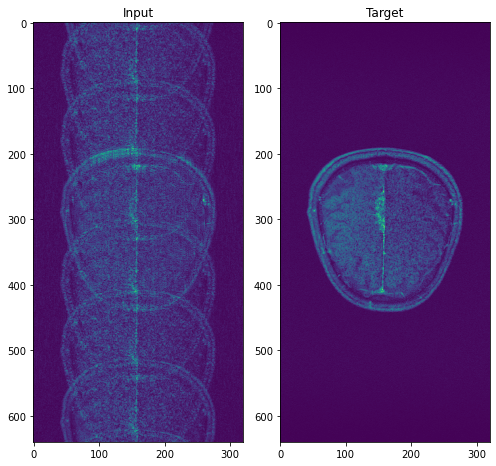

In [5]:
plt.subplot(1,2,1)
plt.imshow(np.abs(input[0, 0, :,: ].numpy()))
plt.title("Input")

plt.subplot(1,2,2)
plt.imshow(target[0,0, :,: ].numpy())
plt.title("Target")

plt.tight_layout()
plt.show()

In [6]:
chans = 32
num_pool_layers = 4
lr = 0.0001

model = Unet(in_chans=1, out_chans=1, chans=chans, num_pool_layers=num_pool_layers)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_list = []

num_epochs = 54 # test on 200 , from 54 not much change
for epoch in range(num_epochs):
    input = Variable(input)
    target = Variable(target)

    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, target)
    loss_list.append(loss.item())

    loss.backward()
    optimizer.step()

    # print(f'Epoch [{epoch+1}/{num_epochs}]')

# Sauvegarder le modèle
torch.save(model.state_dict(), 'fastmri_unet_model.pth')


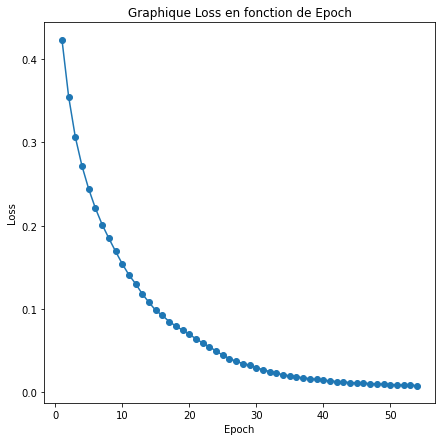

In [7]:
indices = list(range(1, len(loss_list) + 1))

plt.plot(indices, loss_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Graphique Loss en fonction de Epoch')
plt.show()


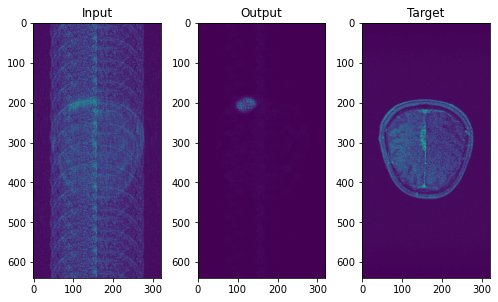

In [8]:
model = Unet(in_chans=1, out_chans=1, chans=chans, num_pool_layers=num_pool_layers)
model.load_state_dict(torch.load('fastmri_unet_model.pth'))

file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"
kspace_multicoil = load_and_transform(file_path)
images_multicoil = torch.fft.fftshift(torch.fft.ifft2(kspace_multicoil))
image = virtual_coil_reconstruction(images_multicoil)
kspace = torch.fft.fft2(image)

zero_filled_reconstruction = torch.fft.fftshift(create_zero_filled_reconstruction(mask,kspace))

test_image = zero_filled_reconstruction

model.eval()
with torch.no_grad():
    predicted_images = model(test_image)
model.train()

plt.subplot(1,3,1)
plt.imshow(np.abs(test_image[0, 0, :,: ].numpy()))
plt.title("Input")

plt.subplot(1,3,2)
plt.imshow(np.abs(predicted_images[0, 0, :,: ].numpy()))
plt.title("Output")

plt.subplot(1,3,3)
plt.imshow(np.abs(image[0,:,:].numpy()))
plt.title("Target")

plt.tight_layout()
plt.show()